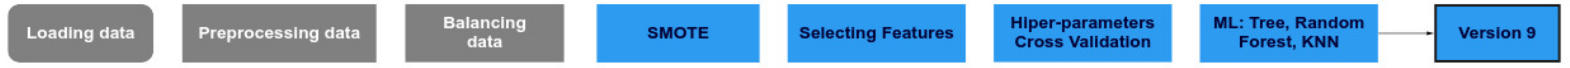

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble            import RandomForestClassifier
from sklearn.tree                import DecisionTreeClassifier
from sklearn.neighbors           import KNeighborsClassifier
from sklearn.linear_model        import LogisticRegression

from sklearn.model_selection     import train_test_split, RandomizedSearchCV
from sklearn.model_selection     import cross_val_score, KFold
from sklearn.metrics             import classification_report, accuracy_score, recall_score, confusion_matrix

import pickle

In [2]:
with open("data_balanced_smote.pkl", 'rb') as f:
    x_train, x_test, y_train, y_test = pickle.load(f)

In [3]:
x_train.shape, y_train.shape

((34992, 23), (34992,))

In [4]:
x_test.shape, y_test.shape

((7500, 23), (7500,))

# FUNCTIONS TO ATTRIBUTE SELECTION

In [5]:
def selecao_atributo(x_treino, y_treino, x_teste, y_teste):
    
    # algoritmo que vai fazer o modelo
    # p: os parametros utilizados, preferencia por usar os hiperparametros
    
    ############################  SELECAO DE ATRIBUTOS AUTOMÁTICA ##############################



    # Criando uma lista de índices com os nomes dos dataframes

    df = ['vazio', 'df1', 'df2', 'df3', 'df4','df5', 'df6', 'df7', 'df8', 'df9',
     'df10', 'df11', 'df12', 'df13', 'df14', 'df15', 'df16', 'df17', 'df18', 'df19']


    # Calculando a Feature Impportance a partir de ML

    model = RandomForestClassifier(n_estimators=25, random_state=0)
    model.fit(x_train, y_train)
    RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
    
    atributos = pd.DataFrame(model.feature_importances_,
                                   index = x_treino.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

    # Armazenando os index em ordem decrescente de F.I em uma lista

    cols = atributos.index

    # Reordenando as colunas a partir da Feature Importance dos DataFrames

    x_treino = x_treino.reindex(columns=cols)
    x_teste = x_teste.reindex(columns=cols)

    # Copiando o DF

    
    
    resultado = {'Colunas': cols, 'X_treino': x_treino, 'Y_treino': y_treino,
                 'X_teste': x_teste,'Y_teste': y_teste}
    
    return resultado

In [6]:
# Seleciona o melhor DF para um algoritmo e seu hiperparâmetro

def melhor_df_by_FI(p,algoritmo, metrica, **resultado):   


    # Criando uma lista de índices com os nomes dos dataframes

    df = ['vazio', 'df1', 'df2', 'df3', 'df4','df5', 'df6', 'df7', 'df8', 'df9',
     'df10', 'df11', 'df12', 'df13', 'df14', 'df15', 'df16', 'df17', 'df18', 'df19']

    # Dict que vai armazenar os datafames e as colunas selecionadas de acordo com a
    # Feature Importance

    features = {}

    # Dict com a porcentagem do recall de cada DF

    recall = {}

    # Percorrendo a lista da penúltima coluna até a primeira (de trás para frente) e 
    # criando novo X para fazer novos treinos e testes dentro do looop
    # E depois armazena o Recall Score em um DICT
    
    
    if metrica == 'recall_score':
        tipo_metrica = 'recall'
    
    if metrica == 'accuracy_score':
        tipo_metrica  = 'accuracy'
    


    for i in range(len(df)-1, 0, -1):
        
        x = resultado['X_treino'][ resultado['Colunas'][:i]]
        xt = resultado['X_teste'][ resultado['Colunas'][:i]]
    
        #x = x_treino[cols[:i]]
        #xt = x_teste[cols[:i]]
        y = resultado['Y_treino'].copy()
   
    
        features[ df[i] ] = resultado['Colunas'][:i].copy()
        
        val_algoritmo = []
    
        for j in range(30):
        
            kfold = KFold(n_splits=10, shuffle=True, random_state=j)
    
            algoritmo(**p)
   
            scores = cross_val_score( algoritmo(**p), x, y, scoring=tipo_metrica, cv = kfold)
            val_algoritmo.append(scores.mean())
    
    
        #print(np.array(val_algoritmo).mean())
        recall[ df[i] ] = np.array(val_algoritmo).mean()


# Criando um DF com os scores ordenados em ordem decrescente
    
    resultados = pd.DataFrame.from_dict(recall.items())
    resultados.columns = ['DataFrame', tipo_metrica]
    resultados = resultados.sort_values(by = tipo_metrica, ascending=False).reset_index()
    resultados.drop(['index'], axis = 1, inplace = True)
    
    return {'Scores': resultados, 'Features': features}

# Selecting the attributes

In [7]:
atributos = selecao_atributo(x_train, y_train, x_test, y_test)
atributos.keys()

dict_keys(['Colunas', 'X_treino', 'Y_treino', 'X_teste', 'Y_teste'])

In [8]:
atributos['Colunas']

Index(['PAY_0', 'PAY_2', 'GENDER', 'EDUCATION', 'MARITAL STATUS', 'BILL_AMT1',
       'LIMIT_BAL', 'PAY_5', 'PAY_3', 'AGE', 'PAY_4', 'PAY_AMT1', 'BILL_AMT3',
       'PAY_AMT2', 'BILL_AMT2', 'PAY_AMT3', 'BILL_AMT4', 'PAY_6', 'BILL_AMT5',
       'PAY_AMT4', 'PAY_AMT5', 'BILL_AMT6', 'PAY_AMT6'],
      dtype='object')

The attributes above were sorted by feature importance. It is reasonable to think that it should exist the best combination of the attributes to maximize the performance for each machine learning algorithm.

# MACHINE LEARNING

In [9]:
version9_accuracy = [] # version10 = [tree, random_forest, knn] for accuracy
version9_recall = [] # version10 = [tree, random_forest, knn] for recall

# Decision Tree

## Filtering Attributes

In [10]:
parametros = {'criterion':['gini', 'entropy'], 'splitter': ['best', 'random'],
              'max_depth':[2, 4, 6, 8, 10, 12, 15], 'min_samples_split':[2, 4, 6, 8],
              'min_samples_leaf':[1, 3, 5, 7, 9]}

In [11]:
grid = RandomizedSearchCV(estimator=DecisionTreeClassifier(), param_distributions= parametros)
grid_result = grid.fit(x_train, y_train)
print(grid_result.best_score_)
print(grid_result.best_params_)

0.8246231599410703
{'splitter': 'best', 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_depth': 8, 'criterion': 'entropy'}


In [12]:
parametros_tree = grid_result.best_params_

best_tree = melhor_df_by_FI(parametros_tree, DecisionTreeClassifier, 'accuracy_score', **atributos)

In [13]:
best_tree.keys()

dict_keys(['Scores', 'Features'])

In [14]:
best_tree['Scores'].head()

,DataFrame,accuracy
0,df5,0.855888
1,df4,0.849921
2,df6,0.842918
3,df9,0.842835
4,df10,0.842349


In [15]:
cols = best_tree['Features']['df5']
cols

Index(['PAY_0', 'PAY_2', 'GENDER', 'EDUCATION', 'MARITAL STATUS'], dtype='object')

In [16]:
x_train_fil_tree = x_train[cols].copy()
x_test_fil_tree = x_test[cols].copy()
y_train_fil_tree = y_train.copy()

## Running

In [17]:
parametros = {"criterion": ['gini', 'entropy'], 'splitter': ['best', 'random'],
             'min_samples_split': [2,3,4], 'random_state': [0],
             'min_samples_leaf': [1, 3, 5], 'max_depth':[1,5,6,10,15,20]}

grid = RandomizedSearchCV(estimator = DecisionTreeClassifier(), param_distributions= parametros)
grid_result = grid.fit(x_train_fil_tree, y_train_fil_tree)
print(grid_result.best_score_)
print(grid_result.best_params_)

0.854174966652036
{'splitter': 'best', 'random_state': 0, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 15, 'criterion': 'entropy'}


In [18]:
parametros_tree = grid_result.best_params_

tree = DecisionTreeClassifier(**parametros_tree)
tree.fit(x_train_fil_tree, y_train_fil_tree)
v9_tree = tree.predict(x_test_fil_tree)

In [19]:
version9_accuracy.append( accuracy_score(y_test, v9_tree) )
version9_recall.append( recall_score(y_test, v9_tree, pos_label='1') )

In [20]:
version9_accuracy

[0.8217333333333333]

In [21]:
version9_recall

[0.35661764705882354]

In [22]:
print(classification_report(y_test, v9_tree))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5868
           1       0.67      0.36      0.47      1632

    accuracy                           0.82      7500
   macro avg       0.76      0.65      0.68      7500
weighted avg       0.80      0.82      0.80      7500



In [23]:
cf_tree = confusion_matrix(y_test, v9_tree)

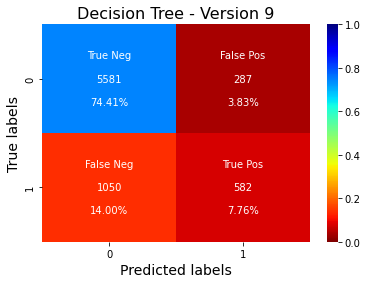

In [24]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts = ["{:0.0f}".format(value) for value in cf_tree.flatten()]

group_percentage = ["{0:0.2%}".format(value) for value in cf_tree.flatten()/np.sum(cf_tree)]

labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1,v2,v3 in zip(group_names, group_counts, group_percentage)]

labels = np.asarray(labels).reshape(2,2)

ax = plt.subplot()



sns.heatmap(cf_tree/np.sum(cf_tree), annot=labels, fmt='', cmap = 'jet_r', vmin = 0, vmax = 1, ax = ax)

ax.set_xlabel('Predicted labels', fontsize = 14)
ax.set_ylabel('True labels', fontsize = 14)

plt.title("Decision Tree - Version 9", fontsize = 16)

plt.show()

# Random Forest

## Filtering Attributes

In [25]:
parametros = {'n_estimators':[75, 100, 125, 150], 'criterion': ['gini', 'entropy'],
              'max_depth':[2, 4, 6, 8, 10, 15], 'min_samples_split':[2, 4, 6, 8, 10],
             'min_samples_leaf': [1, 3, 5, 7, 9]}

In [26]:
grid = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions= parametros)
grid_result = grid.fit(x_train, y_train)
print(grid_result.best_score_)
print(grid_result.best_params_)

0.8387399767761703
{'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 8, 'criterion': 'gini'}


In [27]:
parametros_rf = grid_result.best_params_

In [28]:
best_rf = melhor_df_by_FI(parametros_rf, RandomForestClassifier, 'accuracy_score', **atributos)

In [29]:
best_rf.keys()

dict_keys(['Scores', 'Features'])

In [30]:
best_rf['Scores']

,DataFrame,accuracy
0,df9,0.863525
1,df10,0.863278
2,df5,0.863089
3,df11,0.862878
4,df6,0.860827
5,df8,0.860741
6,df12,0.860480
7,df7,0.859211
8,df13,0.858545
9,df16,0.857216


In [36]:
cols = best_rf['Features']['df9']
cols

Index(['PAY_0', 'PAY_2', 'GENDER', 'EDUCATION', 'MARITAL STATUS', 'BILL_AMT1',
       'LIMIT_BAL', 'PAY_5', 'PAY_3'],
      dtype='object')

In [37]:
x_train_fil_rf = x_train[cols].copy()
x_test_fil_rf = x_test[cols].copy()
y_train_fil_rf = y_train.copy()

## Running Random Forest

In [38]:
parametros = {'n_estimators':[75, 100, 125, 150], 'criterion': ['gini', 'entropy'],
              'max_depth':[2, 4, 6, 8, 10, 15], 'min_samples_split':[2, 4, 6, 8, 10],
             'min_samples_leaf': [1, 3, 5, 7, 9]}

In [40]:
grid = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions= parametros)
grid_result = grid.fit(x_train_fil_rf, y_train_fil_rf)
print(grid_result.best_score_)
print(grid_result.best_params_)

0.8596326809598939
{'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 15, 'criterion': 'entropy'}


In [41]:
parametros_rf = grid_result.best_params_

rf = RandomForestClassifier(**parametros_rf)
rf.fit(x_train_fil_rf, y_train_fil_rf)

v9_rf = rf.predict(x_test_fil_rf)

In [42]:
version9_accuracy.append(accuracy_score(y_test, v9_rf))
version9_recall.append(recall_score(y_test, v9_rf, pos_label='1'))

In [43]:
print(classification_report(y_test, v9_rf))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      5868
           1       0.63      0.38      0.47      1632

    accuracy                           0.82      7500
   macro avg       0.73      0.66      0.68      7500
weighted avg       0.80      0.82      0.80      7500



In [44]:
cf_rf = confusion_matrix(y_test, v9_rf)

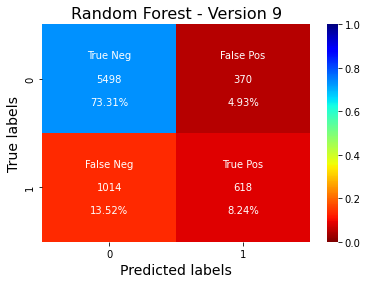

In [45]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts = ["{:0.0f}".format(value) for value in cf_rf.flatten()]

group_percentage = ["{0:0.2%}".format(value) for value in cf_rf.flatten()/np.sum(cf_rf)]

labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1,v2,v3 in zip(group_names, group_counts, group_percentage)]

labels = np.asarray(labels).reshape(2,2)

ax = plt.subplot()



sns.heatmap(cf_rf/np.sum(cf_rf), annot=labels, fmt='', cmap = 'jet_r', vmin = 0, vmax = 1, ax = ax)

ax.set_xlabel('Predicted labels', fontsize = 14)
ax.set_ylabel('True labels', fontsize = 14)

plt.title("Random Forest - Version 9", fontsize = 16)

plt.show()

# KNneighbors

In [46]:
parametros = {'n_neighbors':[2, 3, 4, 5, 6, 7, 8, 10, 12], 'weights':['uniform', 'distance'],
             'algorithm':['ball_tree', 'kd_tree', 'brute', 'auto']}

In [48]:
grid = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions=parametros)
grid_result = grid.fit(x_train, y_train)
print(grid_result.best_score_)
print(grid_result.best_params_)

0.8205880838486663
{'weights': 'distance', 'n_neighbors': 2, 'algorithm': 'auto'}


In [49]:
parametros_knn = grid_result.best_params_

In [52]:
best_knn = melhor_df_by_FI(parametros_knn, KNeighborsClassifier, 'accuracy_score', **atributos)

In [53]:
best_knn.keys()

dict_keys(['Scores', 'Features'])

In [54]:
best_knn['Scores']

,DataFrame,accuracy
0,df5,0.844872
1,df4,0.837723
2,df3,0.817224
3,df19,0.807799
4,df18,0.789794
5,df17,0.789682
6,df16,0.778087
7,df2,0.770339
8,df15,0.763334
9,df1,0.759051


In [55]:
cols = best_knn['Features']['df5']
cols

Index(['PAY_0', 'PAY_2', 'GENDER', 'EDUCATION', 'MARITAL STATUS'], dtype='object')

In [56]:
x_train_fil_knn = x_train[cols].copy()
x_test_fil_knn = x_test[cols].copy()
y_train_fil_knn = y_train.copy()

## Running KNN

In [57]:
parametros = {'n_neighbors':[2, 3, 4, 5, 6, 7, 8, 10, 12], 'weights':['uniform', 'distance'],
             'algorithm':['ball_tree', 'kd_tree', 'brute', 'auto']}

In [58]:
grid = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions=parametros)
grid_result = grid.fit(x_train_fil_knn, y_train_fil_knn)
print(grid_result.best_score_)
print(grid_result.best_params_)

0.8368002108332055
{'weights': 'distance', 'n_neighbors': 4, 'algorithm': 'brute'}


In [60]:
parametros_knn = grid_result.best_params_
knn = KNeighborsClassifier(**parametros_knn)
knn.fit(x_train_fil_knn, y_train_fil_knn)
v9_knn = knn.predict(x_test_fil_knn)

In [61]:
version9_accuracy.append(accuracy_score(y_test, v9_knn))
version9_recall.append(recall_score(y_test, v9_knn, pos_label = '1'))

In [62]:
print(classification_report(y_test, v9_knn))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      5868
           1       0.51      0.29      0.37      1632

    accuracy                           0.79      7500
   macro avg       0.67      0.61      0.62      7500
weighted avg       0.76      0.79      0.76      7500



In [63]:
cf_knn = confusion_matrix(y_test, v9_knn)

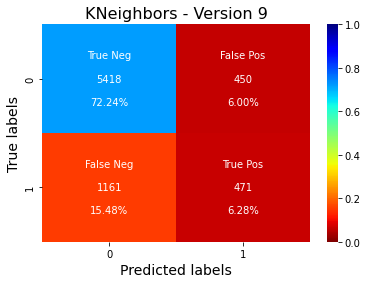

In [64]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts = ["{:0.0f}".format(value) for value in cf_knn.flatten()]

group_percentage = ["{0:0.2%}".format(value) for value in cf_knn.flatten()/np.sum(cf_knn)]

labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1,v2,v3 in zip(group_names, group_counts, group_percentage)]

labels = np.asarray(labels).reshape(2,2)

ax = plt.subplot()



sns.heatmap(cf_knn/np.sum(cf_knn), annot=labels, fmt='', cmap = 'jet_r', vmin = 0, vmax = 1, ax = ax)

ax.set_xlabel('Predicted labels', fontsize = 14)
ax.set_ylabel('True labels', fontsize = 14)

plt.title("KNeighbors - Version 9", fontsize = 16)

plt.show()

# Cross Validation

In [65]:
from sklearn.metrics import precision_score, make_scorer

custom_scorer = make_scorer(recall_score, pos_label="1")

#import warnings
#warnings.filterwarnings('ignore')

resultados_tree_accuracy = []
resultados_random_accuracy = []
resultados_knn_accuracy = []

resultados_tree_recall = []
resultados_random_recall = []
resultados_knn_recall = []



for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    
    tree = DecisionTreeClassifier(**parametros_tree)
    
    scores = cross_val_score(tree, x_train_fil_tree, y_train_fil_tree, scoring=custom_scorer, cv = kfold)
    resultados_tree_recall.append(scores.mean())
    
    scores = cross_val_score(tree, x_train_fil_tree, y_train_fil_tree, scoring='accuracy', cv = kfold)
    resultados_tree_accuracy.append(scores.mean())
    
    print('Tree - Stage: {}'.format(i))
    
    # ==================================================================
        
    rf = RandomForestClassifier(**parametros_rf)
    
    scores = cross_val_score(rf, x_train_fil_rf, y_train_fil_rf,scoring = custom_scorer, cv=kfold)
    resultados_random_recall.append(scores.mean())
    
    scores = cross_val_score(rf, x_train_fil_rf, y_train_fil_rf,scoring = 'accuracy', cv=kfold)
    resultados_random_accuracy.append(scores.mean())
    
    print('Random Forest - Stage: {}'.format(i))
    #===================================================================
    
    knn = KNeighborsClassifier(**parametros_knn)
    
    scores = cross_val_score(knn, x_train_fil_knn, y_train_fil_knn, scoring=custom_scorer, cv=kfold)
    resultados_knn_recall.append(scores.mean())
    
    scores = cross_val_score(knn, x_train_fil_knn, y_train_fil_knn, scoring='accuracy', cv=kfold)
    resultados_knn_accuracy.append(scores.mean())
    
    
    #===================================================================
    print('KNN - Stage: {}'.format(i))

Tree - Stage: 0
Random Forest - Stage: 0
KNN - Stage: 0
Tree - Stage: 1
Random Forest - Stage: 1
KNN - Stage: 1
Tree - Stage: 2
Random Forest - Stage: 2
KNN - Stage: 2
Tree - Stage: 3
Random Forest - Stage: 3
KNN - Stage: 3
Tree - Stage: 4
Random Forest - Stage: 4
KNN - Stage: 4
Tree - Stage: 5
Random Forest - Stage: 5
KNN - Stage: 5
Tree - Stage: 6
Random Forest - Stage: 6
KNN - Stage: 6
Tree - Stage: 7
Random Forest - Stage: 7
KNN - Stage: 7
Tree - Stage: 8
Random Forest - Stage: 8
KNN - Stage: 8
Tree - Stage: 9
Random Forest - Stage: 9
KNN - Stage: 9
Tree - Stage: 10
Random Forest - Stage: 10
KNN - Stage: 10
Tree - Stage: 11
Random Forest - Stage: 11
KNN - Stage: 11
Tree - Stage: 12
Random Forest - Stage: 12
KNN - Stage: 12
Tree - Stage: 13
Random Forest - Stage: 13
KNN - Stage: 13
Tree - Stage: 14
Random Forest - Stage: 14
KNN - Stage: 14
Tree - Stage: 15
Random Forest - Stage: 15
KNN - Stage: 15
Tree - Stage: 16
Random Forest - Stage: 16
KNN - Stage: 16
Tree - Stage: 17
Random For

In [66]:
resultados_accuracy = pd.DataFrame({'Decision Tree': resultados_tree_accuracy, 
                           'Random Forest': resultados_random_accuracy,
                          'KNN': resultados_knn_accuracy})

resultados_recall = pd.DataFrame({'Decision Tree': resultados_tree_recall, 
                           'Random Forest': resultados_random_recall,
                          'KNN': resultados_knn_recall})

In [67]:
resultados_accuracy.to_csv("resultados_accuracy_version9.csv")
resultados_recall.to_csv("resultados_recall_version9.csv")

In [68]:
resultados_accuracy.head()

,Decision Tree,Random Forest,KNN
0,0.867998,0.874343,0.850395
1,0.868627,0.874343,0.844108
2,0.869142,0.874171,0.851623
3,0.868942,0.874314,0.850366
4,0.869056,0.874857,0.846365


In [69]:
resultados_recall.head()

,Decision Tree,Random Forest,KNN
0,0.786443,0.814254,0.750594
1,0.788693,0.814599,0.754446
2,0.789175,0.814113,0.751087
3,0.787879,0.813517,0.750281
4,0.789517,0.813222,0.748484


In [70]:
accuracy_list = []
recall_list = []

for i in range(len(resultados_accuracy.columns)):
    accuracy_list.append( resultados_accuracy[ resultados_accuracy.columns[i] ].mean() )
    recall_list.append( resultados_recall[ resultados_recall.columns[i] ].mean() )

In [71]:
resultados_accuracy.mean()

Decision Tree    0.868613
Random Forest    0.874627
KNN              0.847658
dtype: float64

In [72]:
resultados_recall.mean()

Decision Tree    0.788392
Random Forest    0.813568
KNN              0.752800
dtype: float64

In [73]:
accuracy_list

[0.8686128003919484, 0.8746265586085822, 0.8476576379645883]

In [74]:
recall_list

[0.7883917800938491, 0.8135679134527289, 0.7528002222917122]

In [81]:
accuracy = pd.read_csv('accuracy_versions.csv')
recall = pd.read_csv("recall_versions.csv")

accuracy

,Algorithms,Version 1,Version 2,Version 3,Version 4,Version 5,Version 6,Version 8,Version 7,Version 9,Version 10
0,Decision Tree,0.733600,0.818782,0.721333,0.627600,0.843486,0.695034,0.697112,0.861962,0.695747,0.695747
1,Random Forest,0.819067,0.817401,0.814667,0.750667,0.874799,0.710658,0.703893,0.869996,0.702232,0.702232
2,KNN,0.762133,0.770861,0.607467,0.578533,0.826992,0.606901,0.679966,0.762253,0.671886,0.671886


In [82]:
recall

,Algorithms,Version 1,Version 2,Version 3,Version 4,Version 5,Version 6,Version 8,Version 7,Version 9,Version 10
0,Decision Tree,0.409314,0.358220,0.411152,0.611520,0.777691,0.561127,0.550735,0.793790,0.565944,0.565944
1,Random Forest,0.368260,0.359337,0.395833,0.619485,0.822276,0.621627,0.570543,0.805862,0.620558,0.620558
2,KNN,0.194240,0.097050,0.530025,0.590686,0.936221,0.658990,0.562789,0.706129,0.463968,0.463968


In [83]:
accuracy['Version 9'] = accuracy_list
recall['Version 9'] = recall_list

In [84]:
accuracy

,Algorithms,Version 1,Version 2,Version 3,Version 4,Version 5,Version 6,Version 8,Version 7,Version 9,Version 10
0,Decision Tree,0.733600,0.818782,0.721333,0.627600,0.843486,0.695034,0.697112,0.861962,0.868613,0.695747
1,Random Forest,0.819067,0.817401,0.814667,0.750667,0.874799,0.710658,0.703893,0.869996,0.874627,0.702232
2,KNN,0.762133,0.770861,0.607467,0.578533,0.826992,0.606901,0.679966,0.762253,0.847658,0.671886


In [85]:
recall

,Algorithms,Version 1,Version 2,Version 3,Version 4,Version 5,Version 6,Version 8,Version 7,Version 9,Version 10
0,Decision Tree,0.409314,0.358220,0.411152,0.611520,0.777691,0.561127,0.550735,0.793790,0.788392,0.565944
1,Random Forest,0.368260,0.359337,0.395833,0.619485,0.822276,0.621627,0.570543,0.805862,0.813568,0.620558
2,KNN,0.194240,0.097050,0.530025,0.590686,0.936221,0.658990,0.562789,0.706129,0.752800,0.463968


In [86]:
accuracy.to_csv("accuracy_versions.csv", index=None)

recall.to_csv("recall_versions.csv", index = None)